## Preliminaries

In [3]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO
from numpyro import handlers
from numpyro import optim
from numpyro.handlers import mask
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random
from jax import nn as jnn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score

In [4]:
from jax.scipy.special import ndtr
def norm_cdf (mu, sigma, x):
    scaled_x = (x - mu) / sigma
    return ndtr(scaled_x)

In [5]:
%matplotlib inline
seed = 1
rng_key = random.PRNGKey(seed)

## Generate dummy data

In [6]:
# Generate items
# For now, items described by single attribute - quality
# Each item has a list price determined by that quality
def gen_items(num_items, rng_key):
    keys = random.split(rng_key,2)
    item_quality = dist.Uniform(1, 10).sample(keys[0], (num_items,))
    list_price = jnp.maximum(dist.Normal(item_quality, 1.0).sample(keys[1]),1.0) * 20
    #plt.scatter(item_quality, list_price)
    return item_quality, list_price

_ = gen_items(100, rng_key)

In [7]:
def lognormal_params(mu, sigma):
    loc = np.log(mu**2/np.sqrt(mu**2 + sigma**2))
    scale = np.sqrt(np.log(1 + sigma**2/mu**2))
    return loc, scale


def gen_cust(num_cust, rng_key):
    keys = random.split(rng_key,3)

    beta_quality_loc = dist.Uniform(5,10).sample(keys[0])
    beta_quality_scale = dist.Uniform(1,2).sample(keys[1])
    loc, scale = lognormal_params(beta_quality_loc, beta_quality_scale)
    beta_quality = dist.LogNormal(loc, scale).expand((num_cust,)).sample(keys[2])
    mean_beta_quality = jnp.mean(beta_quality)
    std_beta_quality = jnp.std(beta_quality)
    print('mean_beta_quality: ' + str(mean_beta_quality), 'std_beta_quality: ' + str(std_beta_quality))

    return beta_quality

_ = gen_cust(10, rng_key)

mean_beta_quality: 7.6662745 std_beta_quality: 0.94968593


mean_wtp_bias: -0.058205903 std_wtp_bias: 0.094826534
mean_wtp_uncertainty: 0.2975119 std_wtp_uncertainty: 0.11001105


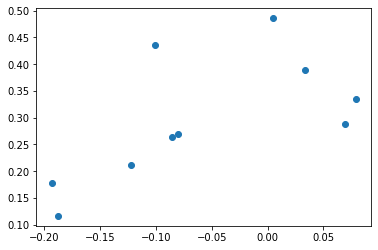

In [8]:
def gen_sales(num_sales, rng_key):
    keys = random.split(rng_key,2)
    sales_wtp_bias = dist.Uniform(-0.2,0.1).expand((num_sales,)).sample(keys[0])
    sales_wtp_uncertainty = dist.Uniform(0.1,0.5).expand([num_sales,]).sample(keys[1])
    print('mean_wtp_bias: ' + str(jnp.mean(sales_wtp_bias)), 'std_wtp_bias: ' + str(jnp.std(sales_wtp_bias)))
    print('mean_wtp_uncertainty: ' + str(jnp.mean(sales_wtp_uncertainty)), 'std_wtp_uncertainty: ' + str(jnp.std(sales_wtp_uncertainty)))
    return sales_wtp_bias, sales_wtp_uncertainty

eg = gen_sales(10, rng_key)
plt.scatter(x=eg[0], y=eg[1])

In [9]:
def gen_quotes(max_items_per_cust, num_cust, num_items, rng_key):
    keys = random.split(rng_key,3)
    concentration = jnp.full(max_items_per_cust, 5.0)
    item_probs = dist.Dirichlet(concentration).sample(keys[0])
    num_item_by_cust = dist.Categorical(item_probs).sample(keys[1], (num_cust,))
    #plt.hist(num_item_by_cust, bins=max_items_per_cust)

    customer_id_list = []
    customer_items_list = []
    key = keys[2]
    for customer, num_items_for_cust in enumerate(num_item_by_cust):
        customer_id_inc = [customer] * num_items_for_cust
        customer_items_inc = random.choice(key, num_items, (num_items_for_cust,), replace=True)
        key = random.split(key,1)[0]
        #customer_items_inc = torch.randperm(num_items)[:num_items_for_cust].tolist()
        customer_id_list.extend(customer_id_inc)
        customer_items_list.extend(customer_items_inc)
        
    customer_id = jnp.array(customer_id_list, dtype=jnp.int32)
    customer_items = jnp.array(customer_items_list, dtype=jnp.int32)
    #print(customer_id.shape, customer_items.shape)

    num_quotes = customer_items.shape[0]
    return customer_id, customer_items, num_quotes

_ = gen_quotes(5, 10, 20, rng_key)

In [10]:
def gen_negotiations(X, rng_key):

    keys = random.split(rng_key,1)

    x_salesperson = jnp.array(X['salesperson'])
    x_item_quality = jnp.array(X['item_quality'])
    x_list_price = jnp.array(X['list_price'])
    x_customer_id = jnp.array(X['customer'])
    x_item = jnp.array(X['item'])
    x_beta_quality = jnp.array(X['beta_quality'])
    x_sales_wtp_bias = jnp.array(X['sales_wtp_bias'])
    x_sales_wtp_uncertainty = jnp.array(X['sales_wtp_uncertainty'])

    num_quotes = len(X)

    y = {}
    key = keys[0]
    for q in range(num_quotes):
        c = x_customer_id[q]
        s = x_salesperson[q]
        i = x_item[q]
        wtp = jnp.minimum(x_item_quality[q] * x_beta_quality[q], x_list_price[q])
        est_wtp = jnp.minimum(dist.Normal(wtp*(1.0+x_sales_wtp_bias[q]), wtp*x_sales_wtp_uncertainty[q]).sample(key), x_list_price[q])
        key = random.split(key,1)[0]
        #print(wtp, x_list_price[q], est_wtp, wtp.dtype, est_wtp.dtype)
        if wtp >= x_list_price[q]:
            result = 1
            price = x_list_price[q]
        if wtp < est_wtp:
            result = 0
            price = np.nan
        else:
            result = 1
            price = ( est_wtp + wtp ) /2
        y[q] = {'result':result, 'price':price, 'wtp':wtp, 'est_wtp':est_wtp}

    return y


In [11]:
def sequential_idx(X):
    # map customer, item and salesperson ids to sequential versions of same for convenience later
    customer_map = {}
    for i, c in enumerate(X['customer'].unique()):
        customer_map[c] = i
    item_map = {}
    for i, item in enumerate(X['item'].unique()):
        item_map[item] = i
    salesperson_map = {}
    for i, s in enumerate(X['salesperson'].unique()):
        salesperson_map[s] = i

    X['customer'] = X['customer'].map(customer_map)
    X['item'] = X['item'].map(item_map)
    X['salesperson'] = X['salesperson'].map(salesperson_map)

    return X

In [12]:
# Generate customers
# Each customer has a view on the value of item quality which determines their willingness to pay

def gen_negs(rng_key):

    keys = random.split(rng_key,6)

    num_items = 100
    item_quality, list_price = gen_items(num_items, keys[0])
    
    num_cust = 10
    beta_quality = gen_cust(num_cust, keys[1])

    # Generate salespeople
    # Each salesperson has an ability to estimate the customers wtp subject to some bias and uncertainty
    num_sales = 10
    sales_wtp_bias, sales_wtp_uncertainty = gen_sales(num_sales, keys[2])

    # Generate quotes
    ## Each customer generates a number of quotes for items
    max_items_per_customer = 100
    customer_id, customer_items, num_quotes = gen_quotes(max_items_per_customer, num_cust, num_items, keys[3])

    ## Salespeople ramdomly assigned to quotes
    salesperson = random.choice(keys[4], num_sales, (num_quotes,), replace=True)

    # Negotiate quotes, get result and agreed price
    X = pd.DataFrame({'customer':customer_id, 'beta_quality':beta_quality[customer_id], 'item':customer_items, 'item_quality':item_quality[customer_items]
        , 'list_price':list_price[customer_items], 'salesperson':salesperson, 'sales_wtp_bias':sales_wtp_bias[salesperson], 'sales_wtp_uncertainty':sales_wtp_uncertainty[salesperson]})

    # map customer, item and salesperson ids to sequential versions of same for convenience later
    X = sequential_idx(X)

    y_dict = gen_negotiations(X, keys[5])
    y = pd.DataFrame.from_dict(y_dict, orient='index', dtype = 'float', columns=['result', 'price', 'wtp', 'est_wtp'])
    
    return pd.concat([X,y], axis=1)


df = gen_negs(rng_key)

mean_beta_quality: 8.115 std_beta_quality: 0.8326588
mean_wtp_bias: -0.026670992 std_wtp_bias: 0.056275062
mean_wtp_uncertainty: 0.31436858 std_wtp_uncertainty: 0.10645751


## Profile dummy data

In [13]:
df.describe(include='all')

,customer,beta_quality,item,item_quality,list_price,salesperson,sales_wtp_bias,sales_wtp_uncertainty,result,price,wtp,est_wtp
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,248.000000,486.000000,486.000000
mean,4.220165,8.142881,46.065844,5.575568,111.954201,4.452675,-0.025324,0.311893,0.510288,38.430744,45.295086,44.221833
std,2.726518,0.899486,28.302267,2.602152,55.826553,2.866951,0.055536,0.105722,0.500409,19.654688,21.690428,26.797148
min,0.000000,6.470518,0.000000,1.073874,20.000000,0.000000,-0.118208,0.195662,0.000000,4.990812,6.948524,-11.691946
25%,2.000000,7.129731,20.250000,3.320693,66.815338,2.000000,-0.078682,0.220202,0.000000,21.953629,26.699370,23.030452
50%,4.000000,8.296275,45.000000,5.433641,116.686821,5.000000,0.014402,0.230783,1.000000,37.785782,44.646160,40.586391
75%,6.000000,8.926371,70.000000,7.930000,162.316589,7.000000,0.018240,0.408138,1.000000,50.991053,62.129179,62.203210
max,8.000000,9.230344,99.000000,9.995341,227.907883,9.000000,0.057598,0.482419,1.000000,89.046722,91.468224,121.348297


In [14]:
df.sample(10)

,customer,beta_quality,item,item_quality,list_price,salesperson,sales_wtp_bias,sales_wtp_uncertainty,result,price,wtp,est_wtp
250,4,9.230344,85,2.738845,27.803514,7,-0.072739,0.453076,0.0,NaN,25.280479,27.803514
422,8,7.129731,79,4.182418,102.972992,0,0.014402,0.342795,0.0,NaN,29.819517,41.930939
466,8,7.129731,95,8.432952,177.483032,8,-0.081994,0.482419,1.0,47.400166,60.124676,34.675655
92,1,8.981909,20,9.213822,173.964203,5,-0.044349,0.228962,1.0,80.028145,82.757713,77.298576
118,2,8.330773,75,1.195650,20.000000,1,0.022551,0.195662,1.0,8.869936,9.960689,7.779182
32,0,6.470518,27,6.169623,176.162186,1,0.022551,0.195662,1.0,39.030220,39.920658,38.139778
470,8,7.129731,57,2.884091,61.020218,2,-0.078682,0.408138,0.0,NaN,20.562792,27.562677
350,6,8.261777,41,6.528025,129.708893,2,-0.078682,0.408138,1.0,47.012825,53.933086,40.092567
158,3,8.926371,48,4.679685,66.815338,8,-0.081994,0.482419,1.0,25.121880,41.772602,8.471157
455,8,7.129731,64,7.987077,175.038132,3,-0.118208,0.385435,1.0,50.481033,56.945709,44.016357


<AxesSubplot:ylabel='Frequency'>

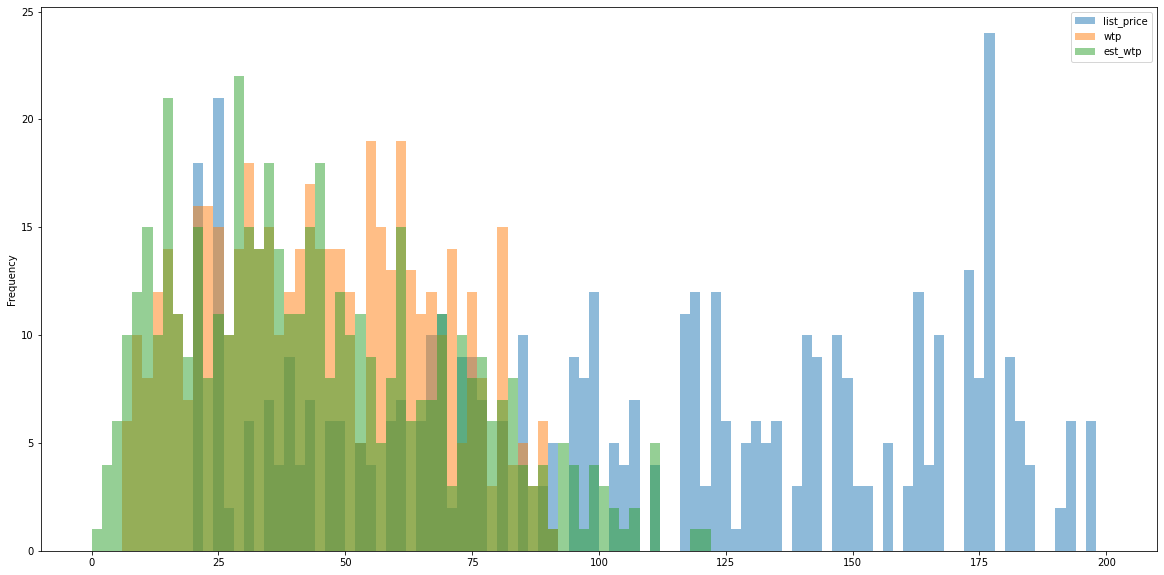

In [15]:
# Distribution of price-like variables
df[['list_price', 'wtp', 'est_wtp']].plot.hist(bins=100, alpha=0.5, figsize=(20,10), range=(0,200))

<AxesSubplot:xlabel='index', ylabel='price'>

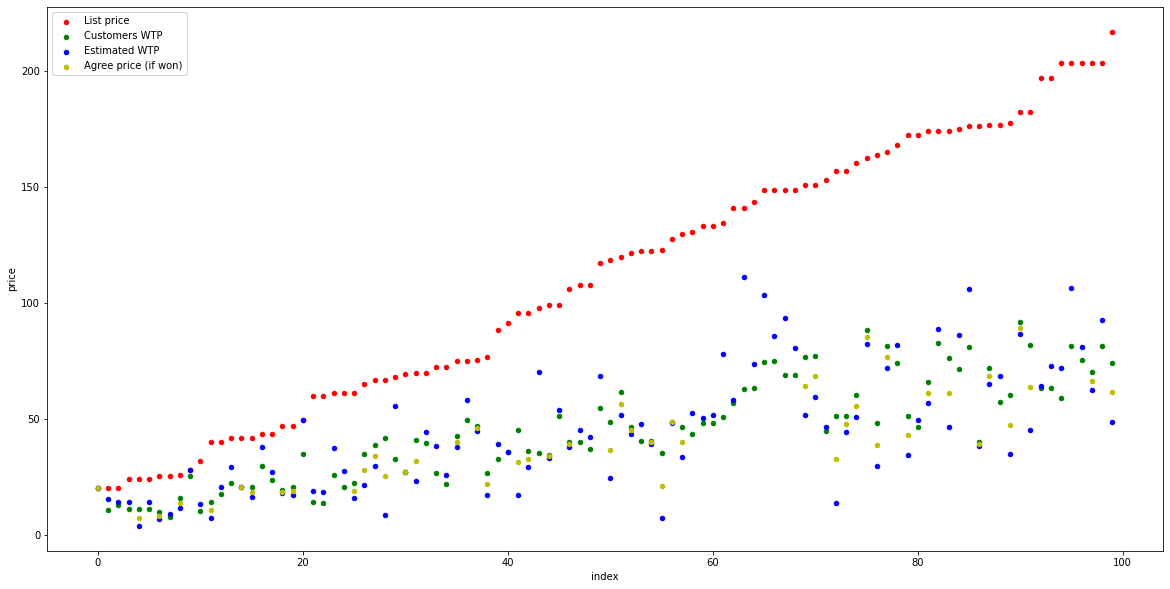

In [16]:
# Prices for random sample of quotes
examples = df.sample(100).sort_values(by='list_price').reset_index(drop=True).reset_index()
ax = examples.plot.scatter(x='index', y='list_price', color='r', label='List price', figsize=(20,10))
examples.plot.scatter(x='index', y='wtp', color='g', label='Customers WTP', ax=ax)
examples.plot.scatter(x='index', y='est_wtp', color='b', label='Estimated WTP', ax=ax)
examples.plot.scatter(x='index', y='price', color='y', label='Agree price (if won)', ax=ax)

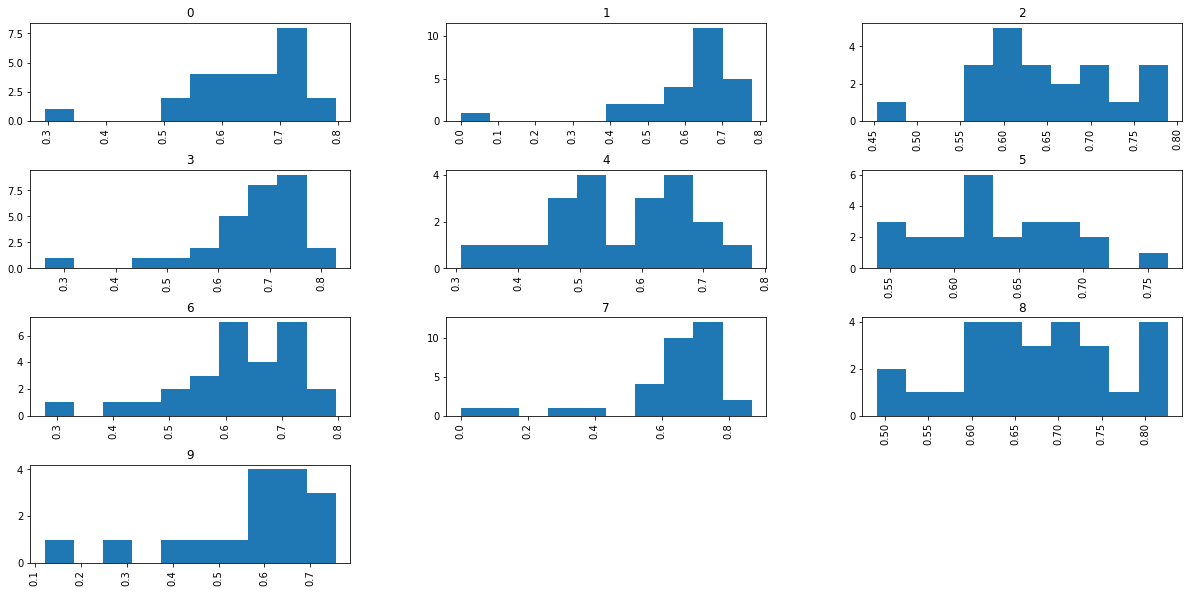

In [17]:
# Distribution of discounts on won deals by salesperson
df['discount'] = np.where(df['result']==1, 1 - df['price']/df['list_price'], np.nan)
_ = df['discount'].hist(by=df['salesperson'], figsize=(20,10))

### Analysis by salesperson

In [18]:
ss = df.reset_index().groupby('salesperson').agg({'index':'count', 'discount':'mean', 'result':'mean'
    , 'wtp':'sum', 'price':'sum', 'sales_wtp_bias':'mean', 'sales_wtp_uncertainty':'mean'})
ss['pct_wtp_captured'] = ss['price']/ss['wtp']
ss.to_csv('ss.csv')

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:78

Best number of neighbours: {'n_neighbors': 5}


/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Text(0, 0.5, 'wtp_uncertainty')

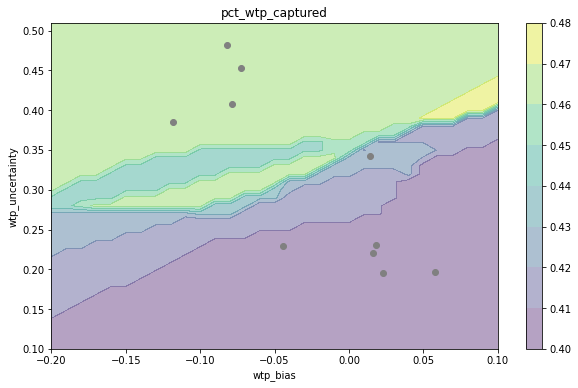

In [19]:
# Get data into numpy arrays
X=ss[['sales_wtp_bias','sales_wtp_uncertainty']].values
y=ss['pct_wtp_captured'].values.reshape(-1, 1)

# Train knn model
num_neigh = np.arange(5, 150, 10)
hyperparameters = dict(n_neighbors=num_neigh)
knr = KNeighborsRegressor()
tune_neigh = GridSearchCV(knr, hyperparameters, cv=10)
neigh = tune_neigh.fit(X,y)
print('Best number of neighbours: ' + str(tune_neigh.best_params_))

# Predict field over range of x1, x2
x1_values = np.arange(-0.2, 0.1, 0.01)
x2_values = np.arange(0.1, 0.52, 0.01)
xx1, xx2 = np.meshgrid(x1_values, x2_values)
X_pred = np.array([xx1.ravel(), xx2.ravel()]).T
z = neigh.predict(X_pred)

# Plot field and also show where individual points are
fig, ax = plt.subplots(figsize=(10,6))
cf = ax.contourf(xx1, xx2, z.reshape(xx1.shape), alpha = 0.4)#, norm=norm)
fig.colorbar(cf, ax=ax)
ax.scatter(x=X[:,0], y=X[:,1], c='grey')
ax.set_title('pct_wtp_captured')
ax.set_xlabel('wtp_bias')
ax.set_ylabel('wtp_uncertainty')

## Model

In [20]:
X = df[['customer', 'item',	'list_price', 'salesperson', 'item_quality']]
y = df[['result', 'price']]

In [21]:
def model(X, y=None, debug =False):

    x_salesperson = jnp.array(X['salesperson'])
    x_item_quality = jnp.array(X['item_quality'])
    x_list_price = jnp.array(X['list_price'])
    x_customer = jnp.array(X['customer'])

    if y is not None:
        y_result = jnp.array(y['result'], dtype='int32')
        y_price = jnp.array(y['price'])
    
    # Salespeople
    num_sales = X['salesperson'].nunique() # number of salespeople in data
    # prior on bias in salespersons estimate of customers wtp, a proportion of the wtp
    sales_wtp_bias_mean = numpyro.sample(
        "sales_wtp_bias_pct_mean",
        dist.Normal(-0.2,0.1)
    )
    sales_wtp_bias_sigma = numpyro.sample(
        "sales_wtp_bias_pct_sigma",
        dist.HalfNormal(0.2)
    )
    # a prior on the mean error in the salespersons estimate of the customers wtp, a proportion of the wtp
    sales_wtp_uncertainty_scale = numpyro.sample(
        "sales_wtp_uncertainty_pct_scale",
        dist.TruncatedNormal(low = 0.01, loc=0.4, scale=0.2)
    )
    # sample salespeople
    with numpyro.plate('salespeople', num_sales):
        with numpyro.handlers.reparam(config={"sales_wtp_bias_pct": TransformReparam()}):
            sales_wtp_bias = numpyro.sample(
                "sales_wtp_bias_pct",
                dist.TransformedDistribution(
                    dist.Normal(loc=jnp.zeros((num_sales)), scale=1.0),
                    dist.transforms.AffineTransform(sales_wtp_bias_mean, sales_wtp_bias_sigma),
                ),
            )
    #     unscaled_sales_wtp_uncertainty = numpyro.sample(
    #         "unscaled_sales_wtp_uncertainty", 
    #         dist.HalfNormal(scale=1.0).expand((num_sales,))
    #     )
    # sales_wtp_uncertainty = numpyro.deterministic("sales_wtp_uncertainty_pct", sales_wtp_uncertainty_scale * unscaled_sales_wtp_uncertainty)
        sales_wtp_uncertainty = numpyro.sample("sales_wtp_uncertainty_pct", dist.HalfNormal(scale=sales_wtp_uncertainty_scale).expand((num_sales,)))
        # with pyro.poutine.reparam(config={"sales_wtp_uncertainty_pct": TransformReparam()}):
        #     sales_wtp_uncertainty = pyro.sample(
        #         "sales_wtp_uncertainty_pct",
        #         dist.TransformedDistribution(
        #             dist.HalfNormal(scale=torch.ones((num_sales,))),
        #             dist.transforms.AffineTransform(0.0, sales_wtp_uncertainty_scale),
        #         ),
        #     )
        # with pyro.poutine.reparam(config={"sales_wtp_uncertainty_pct": LocScaleReparam()}):#centered=0)}):
        #     sales_wtp_uncertainty = pyro.sample(
        #         "sales_wtp_uncertainty_pct",
        #         dist.LogNormal(loc=0.0, scale=sales_wtp_uncertainty_scale).expand([num_sales,])
        #     )
    #print(sales_wtp_uncertainty_scale)
    #print(sales_wtp_uncertainty)
        excess_wtp_dist_sales = dist.Normal(-1.0*sales_wtp_bias, sales_wtp_uncertainty)
        prob_win_sales = 1.0 - excess_wtp_dist_sales.cdf(0.0)
        print(prob_win_sales)



    #print('salespeople shapes: ', sales_wtp_bias.shape, sales_wtp_uncertainty.shape)

    # Customers
    num_cust= X['customer'].nunique()
    #num_cust = len(X) # number of customers (and rows) in data
    #print(num_cust)
    #prior_beta_quality_loc = pyro.distributions.Uniform(5,10) # prior of the mean of the coefficient of item quality in customers assessment of their wtp, £ per unit of quality
    #prior_beta_quality_scale = pyro.distributions.Uniform(1,2) # prior of the std deviation of the coefficient of item quality in customers assessment of their wtp, £ per unit of quality
    beta_quality_loc = numpyro.sample("beta_quality_loc", 
            dist.TransformedDistribution(
                dist.Uniform(5,15),
                dist.transforms.ExpTransform().inv
            )
    ) # sample mean betas from prior distribution
    beta_quality_scale = numpyro.sample("beta_quality_scale", 
        dist.InverseGamma(1, 1)
    )
    #print(beta_quality_loc, beta_quality_scale)
     # # sample std deviation of beta from prior distribution
    #print(beta_quality_loc, beta_quality_scale)
    #beta_quality = torch.distributions.LogNormal(beta_quality_loc, beta_quality_scale).sample([num_cust,])
    #print(beta_quality.shape)


    with numpyro.plate('customers', num_cust): #sample customers, all from same distribution for now
    #     with pyro.poutine.reparam(config={"beta_quality": TransformReparam()}):
    #         beta_quality = pyro.sample(
    #             "beta_quality",
    #             dist.TransformedDistribution(
    #                 dist.Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0)).expand([num_cust,]),
    #                 dist.transforms.AffineTransform(beta_quality_loc, beta_quality_scale),
    #             ),
    #         )

        # with pyro.poutine.reparam(config={"beta_quality": LocScaleReparam()}):#centered=0)}):
        #     beta_quality = pyro.sample(
        #         "beta_quality",
        #         dist.LogNormal(loc=beta_quality_loc, scale=beta_quality_scale).expand([num_cust,])
        #     )
        with numpyro.handlers.reparam(config={"beta_quality": LocScaleReparam(centered=0)}):
            beta_quality = numpyro.sample("beta_quality", dist.LogNormal(beta_quality_loc, beta_quality_scale).expand([num_cust,]))

    #print('customer params shape: ', beta_quality.shape)
    #print(x_item_quality.shape, beta_quality.shape, x_customer.shape, x_list_price.shape)
    #wtp = pyro.deterministic("wtp", torch.clamp(x_item_quality * beta_quality[x_customer], min=torch.ones_like(x_list_price), max=x_list_price))
    wtp_unbound = x_item_quality * beta_quality[x_customer]
    #print(wtp_unbound.shape)
    wtp = jnn.softplus(wtp_unbound)
    
    #_ = plt.hist(wtp, bins=50)
    #print(wtp.shape)
    #print(wtp.shape, sales_wtp_uncertainty.shape, x_salesperson.shape)
    wtp_uncertainty = wtp * sales_wtp_uncertainty[x_salesperson]
    print(sales_wtp_uncertainty)
    print(wtp_uncertainty.min())
    #_ = plt.hist(wtp_uncertainty, bins=50)
    #print(wtp_uncertainty.shape)
    #print('wtp shapes: ', wtp.shape, wtp_uncertainty.shape)
    #print('shape of x_list_price:', x_list_price.shape)
    #print(wtp_uncertainty.min(), wtp.min(), sales_wtp_uncertainty[x_salesperson].min())
    #print(sales_wtp_uncertainty)
    #est_wtp = torch.clamp(
    #print(sales_wtp_bias.shape) 
    #print(x_salesperson.shape)
    #print(sales_wtp_bias[x_salesperson].shape)
    #est_wtp_loc = wtp*(1.0+sales_wtp_bias[x_salesperson])
    # with numpyro.handlers.reparam(config={"estimated_wtp": LocScaleReparam(centered=0)}):
    #     est_wtp = numpyro.sample(
    #             "estimated_wtp",
    #             dist.TruncatedNormal(low=0.01, loc=est_wtp_loc, scale=wtp_uncertainty)
    #                 #numpyro.distributions.Normal(, y)
    #             )
        #), 
        #min=torch.ones_like(x_list_price), 
        #max=x_list_price
    #)

    # with numpyro.handlers.reparam(config={"excess_wtp": TransformReparam()}):
    #     excess_wtp = numpyro.sample(
    #             "excess_wtp",
    #             dist.TransformedDistribution(
    #                 dist.Normal(loc=0., scale=jnp.ones_like(wtp_uncertainty)),
    #                 AffineTransform(wtp*sales_wtp_bias[x_salesperson], wtp_uncertainty),
    #             )
    #     )

    # excess_wtp_dist = dist.TransformedDistribution(
    #                 dist.Normal(loc=0., scale=jnp.ones_like(wtp_uncertainty)),
    #                 AffineTransform(wtp*sales_wtp_bias[x_salesperson], wtp_uncertainty),
    #             )
    excess_wtp_loc = -1.0*wtp*sales_wtp_bias[x_salesperson]
    # excess_wtp_dist_base = dist.Normal(0.0, jnp.ones_like(wtp_uncertainty))
    # excess_wtp_dist = dist.TransformedDistribution(
    #     excess_wtp_dist_base,
    #     AffineTransform(excess_wtp_loc,wtp_uncertainty)
    #     )
    
    #dist.Normal(loc=excess_wtp_loc, scale=wtp_uncertainty)
    base_low = (0.0-excess_wtp_loc)/wtp_uncertainty
    excess_wtp_dist_if_won = dist.TransformedDistribution(
        dist.TruncatedNormal(low=base_low, loc=0.0, scale=jnp.ones_like(wtp_uncertainty)),
        AffineTransform(excess_wtp_loc,wtp_uncertainty)
    )

    #excess_wtp_dist_if_won = dist.TruncatedNormal(low = 0.0, loc=excess_wtp_loc, scale=wtp_uncertainty)

    #_ = plt.hist(excess_wtp_loc, bins = 25)

    #print('shape of est_wtp', est_wtp.shape)
    #prob_win = 1.0 - excess_wtp_dist.cdf(0.0)
    #prob_win = 1.0 - norm_cdf(excess_wtp_loc, wtp_uncertainty, 0.0)
    prob_win = prob_win_sales[x_salesperson]
    #_ = plt.hist(prob_win, bins = 25)
    #prob_win = jnp.where(excess_wtp < 0, jnp.zeros_like(x_list_price), jnp.ones_like(x_list_price))
    #prob_win = jnn.sigmoid(wtp - est_wtp)
    with numpyro.handlers.reparam(config={"excess_wtp_if won": TransformReparam()}):
        excess_wtp_if_won = numpyro.sample("excess_wtp_if_won",excess_wtp_dist_if_won)

    num_quotes = len(X)
    with numpyro.plate('negotiations', num_quotes):
        
        result = numpyro.sample("result", dist.BernoulliProbs(prob_win), obs = None if y is None else y_result==1.0)
        hidden_price_if_won = wtp + excess_wtp_if_won/2
        #hidden_price = jnp.where(wtp < x_list_price, (est_wtp+wtp) /2, x_list_price)
        if y is not None:
            obs_mask = jnp.logical_and(y_result == 1.0, result == 1.0)
            with mask(mask = obs_mask):
                price = numpyro.sample("price_if_won", dist.Normal(hidden_price_if_won, 0.01), obs = y_price)#[mask])#None if y is None else y_price)
                #price = pyro.sample("price_if_won", pyro.distributions.Delta(hidden_price), obs = y_price)#[mask])#None if y is None else y_price)
        else:
            price = jnp.where(result == 1.0, 
                numpyro.sample("price_if_won", numpyro.distributions.Normal(hidden_price_if_won, 0.01)), np.nan)


    #outcome[c] = {'item':i, 'result':result, 'price':hidden_price, 'list_price':list_price[i].item(), 'wtp':wtp.item(), 'est_wtp':est_wtp.item(), 'salesperson':s}
    if debug:
        return result, hidden_price_if_won, price, prob_win, excess_wtp_loc, wtp_uncertainty
    else:
        return result, hidden_price_if_won, price #None if y is None else priceresult, hidden_price_if_won, price, 

In [22]:
y_gen = numpyro.handlers.seed(model, rng_key)(X, y=None, debug=True)

[1.         0.76054347 0.7557636  1.         1.         0.9529309
 0.53018844 0.62021863 0.78402513 0.9205798 ]
[0.02085557 0.36116382 0.6429266  0.05934013 0.01482069 0.1089547
 0.29481927 0.4394492  0.15496926 0.43014044]
0.061638582


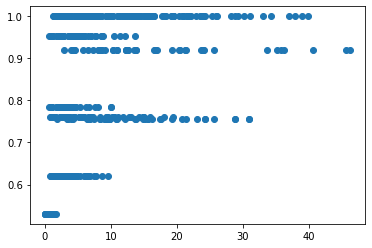

In [23]:
_ = plt.scatter(y_gen[4], y_gen[3])

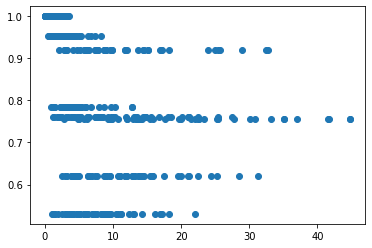

In [24]:
_ = plt.scatter(y_gen[5], y_gen[3])

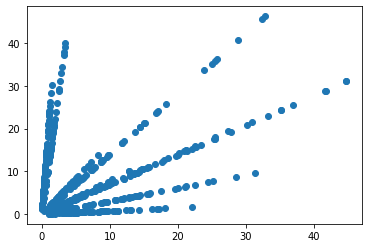

In [25]:
_ = plt.scatter(y_gen[5], y_gen[4])

38.430744199983536 33.9611


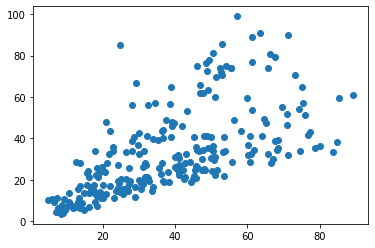

In [26]:
plt.scatter(x=y['price'], y=y_gen[1])
print(y['price'].mean(), y_gen[1].mean())

In [27]:
print(y['result'].mean(), y_gen[0].mean())

0.5102880658436214 0.7983539


In [28]:
y_gen_df = pd.DataFrame(
        {'result':y_gen[0], 'price':y_gen[2]}
    )

In [29]:
y_gen_df

,result,price
0,1,21.496525
1,1,32.562561
2,1,74.178185
3,1,68.085052
4,1,57.796211
...,...,...
481,1,29.482782
482,0,NaN
483,1,34.438900
484,0,NaN


In [30]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=200, num_samples=1000)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, X, y_gen_df)
mcmc.print_summary()

[1.6510487e-05 0.0000000e+00 6.3872910e-01 9.6114641e-01 3.1076252e-02
 7.9151553e-01 3.2158494e-03 1.0000000e+00 9.2969084e-01 2.6226044e-06]
[0.25636938 0.19159703 2.6931646  1.0402436  1.1934911  4.730263
 1.771874   0.25540668 0.41030604 1.3021418 ]
0.1585398
Traced<ConcreteArray([1.6510487e-05 0.0000000e+00 6.3872910e-01 9.6114641e-01 3.1076252e-02
 7.9151553e-01 3.2158494e-03 1.0000000e+00 9.2969084e-01 2.6226044e-06], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray([1.6510487e-05, 0.0000000e+00, 6.3872910e-01, 9.6114641e-01,
             3.1076252e-02, 7.9151553e-01, 3.2158494e-03, 1.0000000e+00,
             9.2969084e-01, 2.6226044e-06], dtype=float32)
  tangent = Traced<ShapedArray(float32[10])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[10]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fa924231510>, invars=(Traced<ShapedArray(float32[10]):JaxprTrace(level=1/0)>,), outvars=[<weakref at 0x7fa92424a590; to 'JaxprTracer' a

  0%|          | 0/1200 [00:00<?, ?it/s]

Traced<ShapedArray(float32[10])>with<JVPTrace(level=4/1)> with
  primal = Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=2/1)>
  tangent = Traced<ShapedArray(float32[10])>with<JaxprTrace(level=3/1)> with
    pval = (ShapedArray(float32[10]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fa9486289e0>, invars=(Traced<ShapedArray(float32[10]):JaxprTrace(level=3/1)>,), outvars=[<weakref at 0x7fa9242b2360; to 'JaxprTracer' at 0x7fa9242b29f0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(<lambda>)', 'donated_invars': (False,), 'inline': True, 'call_jaxpr': { lambda ; a:f32[10]. let b:f32[10] = neg a in (b,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fa94869ba70>)
Traced<ShapedArray(float32[10])>with<JVPTrace(level=4/1)> with
  primal = Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=2/1)>
  tangent = Traced<ShapedArray(float32[10])>with<JaxprTrace(level=3/1)> with
    pval = (ShapedArray(float32[10]), *)


sample: 100%|██████████| 1200/1200 [07:32<00:00,  2.65it/s, 1023 steps of size 6.48e-09. acc. prob=0.84]


Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/1)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/1)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/1)>

                                       mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta_quality_decentered[0]      0.70      0.00      0.70      0.70      0.70      0.50      1.00
       beta_quality_decentered[1]      0.50      0.00      0.50      0.50      0.50      0.50      1.00
       beta_quality_decentered[2]      1.08      0.00      1.08      1.08      1.08      0.50      1.00
       beta_quality_decentered[3]      0.63      0.00      0.63      0.63      0.63      0.50      1.00
       beta_quality_decentered[4]      1.29      0.00      1.29      1.29      1.29      0.50      1.00
       beta_quality_decentered[5]      0.32      0.00      0.32      0.32      0.32      0.50      1.00
       beta_quality_decentered[6]      2.86      0.00      2.86      2.8

In [31]:
from numpyro.infer.autoguide import AutoLaplaceApproximation

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, X, y_gen_df)
params = svi_result.params
# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
numpyro.diagnostics.print_summary(samples, group_by_chain=False)

[0.07698584 1.         1.         0.         1.         0.
 0.05260569 0.09448832 0.9992509  1.        ]
[2.3140733  0.1970801  0.5340935  1.5416455  0.1767491  0.14455904
 1.0720379  2.8510246  3.2603006  1.515747  ]
1.2128198e-06
Traced<ConcreteArray([0.07698584 1.         1.         0.         1.         0.
 0.05260569 0.09448832 0.9992509  1.        ], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray([0.07698584, 1.        , 1.        , 0.        , 1.        ,
             0.        , 0.05260569, 0.09448832, 0.9992509 , 1.        ],            dtype=float32)
  tangent = Traced<ShapedArray(float32[10])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[10]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fa91c609c20>, invars=(Traced<ShapedArray(float32[10]):JaxprTrace(level=1/0)>,), outvars=[<weakref at 0x7fa9242b2950; to 'JaxprTracer' at 0x7fa9242b29f0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(<lambda>

  0%|          | 0/1000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[10])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[10])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[10]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fa8f462bd50>, invars=(Traced<ShapedArray(float32[10]):JaxprTrace(level=1/1)>,), outvars=[<weakref at 0x7fa94848cb80; to 'JaxprTracer' at 0x7fa94848ccc0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(<lambda>)', 'donated_invars': (False,), 'inline': True, 'call_jaxpr': { lambda ; a:f32[10]. let b:f32[10] = neg a in (b,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7fa8f45ed7b0>)
Traced<ShapedArray(float32[10])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[10])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[10]), *)


100%|██████████| 1000/1000 [00:04<00:00, 247.64it/s, init loss: 18867718144.0000, avg. loss [951-1000]: nan]


Traced<ConcreteArray([nan nan nan nan nan nan nan nan nan nan], dtype=float32)>with<JVPTrace(level=4/0)> with
  primal = Traced<ConcreteArray([nan nan nan nan nan nan nan nan nan nan], dtype=float32)>with<JVPTrace(level=2/0)> with
    primal = DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)
    tangent = Traced<ShapedArray(float32[10])>with<BatchTrace(level=1/0)> with
      val = DeviceArray([[nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             ...,
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
      batch_dim = 0
  tangent = Traced<ShapedArray(float32[10])>with<JaxprTrace(level=3/0)> with
    pval = (ShapedArray(float32[10]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fa8f440f280>, invars=(Traced<ShapedArray(float32[10]):Jaxp

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/autoguide.py:1087: UserWarning: Hessian of log posterior at the MAP point is singular. Posterior samples from AutoLaplaceApproxmiation will be constant (equal to the MAP point). Please consider using an AutoNormal guide.
  warnings.warn(


Traced<ConcreteArray(nan, dtype=float32)>with<JVPTrace(level=4/0)> with
  primal = Traced<ConcreteArray(nan, dtype=float32)>with<JVPTrace(level=2/0)> with
    primal = DeviceArray(nan, dtype=float32)
    tangent = Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
      val = DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, n

In [162]:
samples = mcmc.get_samples()
predictive = Predictive(model, samples, return_sites=['result', 'price_if_won'])
pred_y = predictive(random.split(rng_key,1)[0], X)

Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>


R2: 82%
AUC: 47%


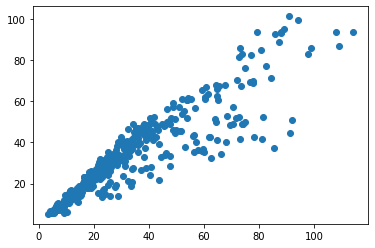

In [163]:
def metrics(act_y, pred_y):
    idx = jnp.array([act_y['result']==1.0][0])
    p = pred_y['price_if_won'].mean(axis=0)[idx]
    t = jnp.array(act_y['price'])[idx]

    print(f"R2: {r2_score(t, p):.0%}\nAUC: {roc_auc_score(act_y['result'], pred_y['result'].mean(axis=0), multi_class='ovo'):.0%}")
    plt.scatter(t, p)

metrics(y_gen_df, pred_y)

Index(['customer', 'item', 'list_price', 'salesperson', 'item_quality',
       'result', 'price', 'pred_result_mean', 'pred_price_mean'],
      dtype='object')


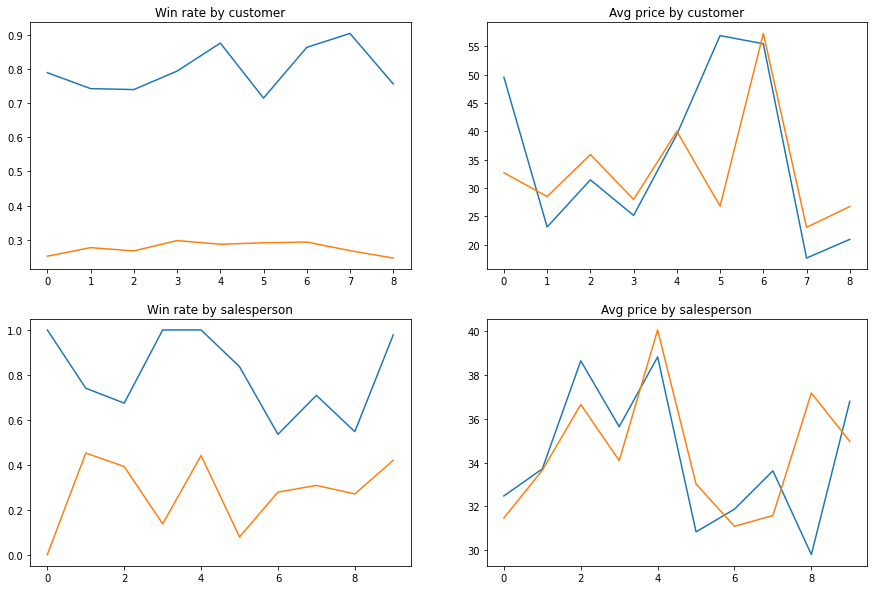

In [164]:
def pred_act_charts(X, act_y, pred_y):

    # Conversion rate by customer and salesperson
    tdf = pd.concat([X, act_y], axis=1)
    tdf['pred_result_mean'] = pred_y['result'].mean(axis=0)
    tdf['pred_price_mean'] = pred_y['price_if_won'].mean(axis=0)
    print(tdf.columns)

    fig, axs = plt.subplots(2,2,figsize=(15,10))
    c = tdf.reset_index().groupby('customer').agg({'index':'count', 'result':'mean', 'pred_result_mean':'mean', 
        'price':'mean', 'pred_price_mean':'mean'})
    axs[0,0].plot(c[['result','pred_result_mean']])
    axs[0,0].set_title('Win rate by customer')
    axs[0,1].plot(c[['price','pred_price_mean']])
    axs[0,1].set_title('Avg price by customer')
    s = tdf.reset_index().groupby('salesperson').agg({'index':'count', 'result':'mean', 'pred_result_mean':'mean', 
        'price':'mean', 'pred_price_mean':'mean'})
    axs[1,0].plot(s[['result','pred_result_mean']])
    axs[1,0].set_title('Win rate by salesperson')
    axs[1,1].plot(s[['price','pred_price_mean']])
    axs[1,1].set_title('Avg price by salesperson')

pred_act_charts(X, y_gen_df, pred_y)

In [99]:
samples.keys()

dict_keys(['beta_quality', 'beta_quality_decentered', 'beta_quality_loc', 'beta_quality_scale', 'excess_wtp_if_won', 'sales_wtp_bias_pct', 'sales_wtp_bias_pct_base', 'sales_wtp_bias_pct_mean', 'sales_wtp_bias_pct_sigma', 'sales_wtp_uncertainty_pct', 'sales_wtp_uncertainty_pct_scale'])

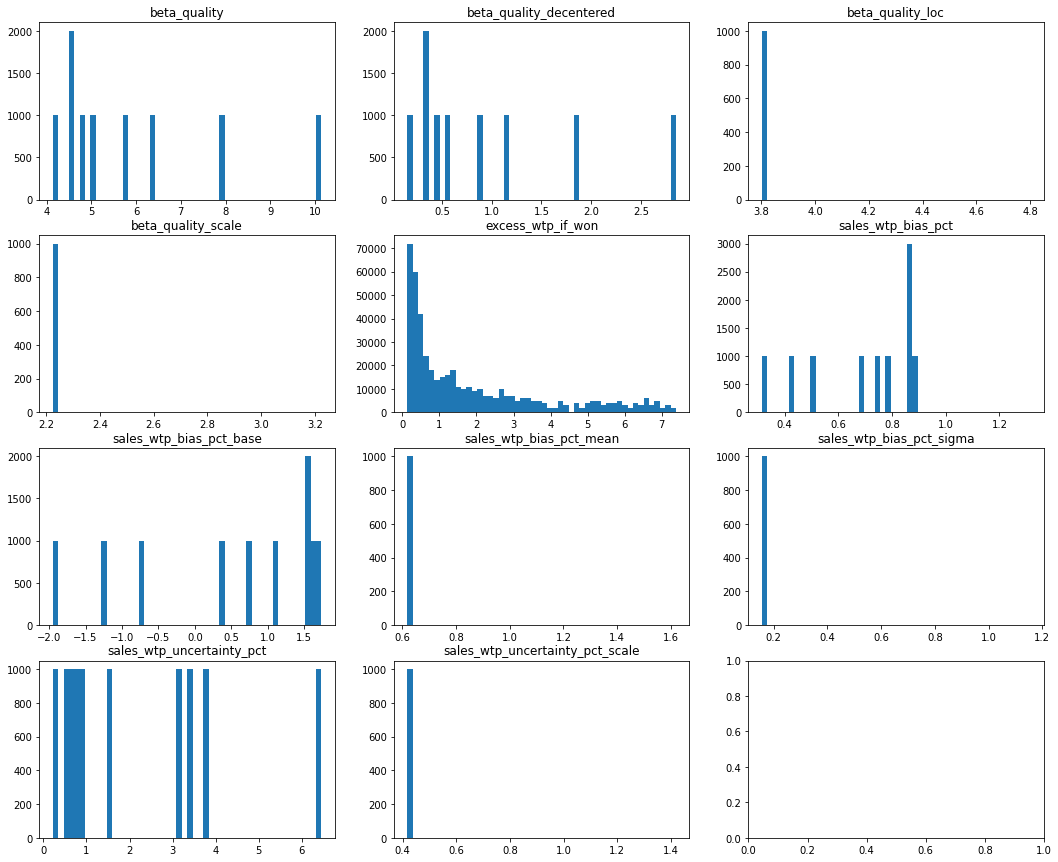

In [100]:
num_plots = len(samples.keys())
columns = 3
whole_rows, part_rows = divmod(num_plots, columns)
rows = whole_rows + int(part_rows>0)
fig,axs = plt.subplots(rows,columns, figsize=(18,15))
axs = axs.ravel()
for i, (site, data) in enumerate(samples.items()):
    axs[i].hist(jnp.ravel(data), bins = 50, range=(jnp.min(data), max(min(jnp.max(data),50),jnp.min(data)+1)))
    axs[i].set_title(site)


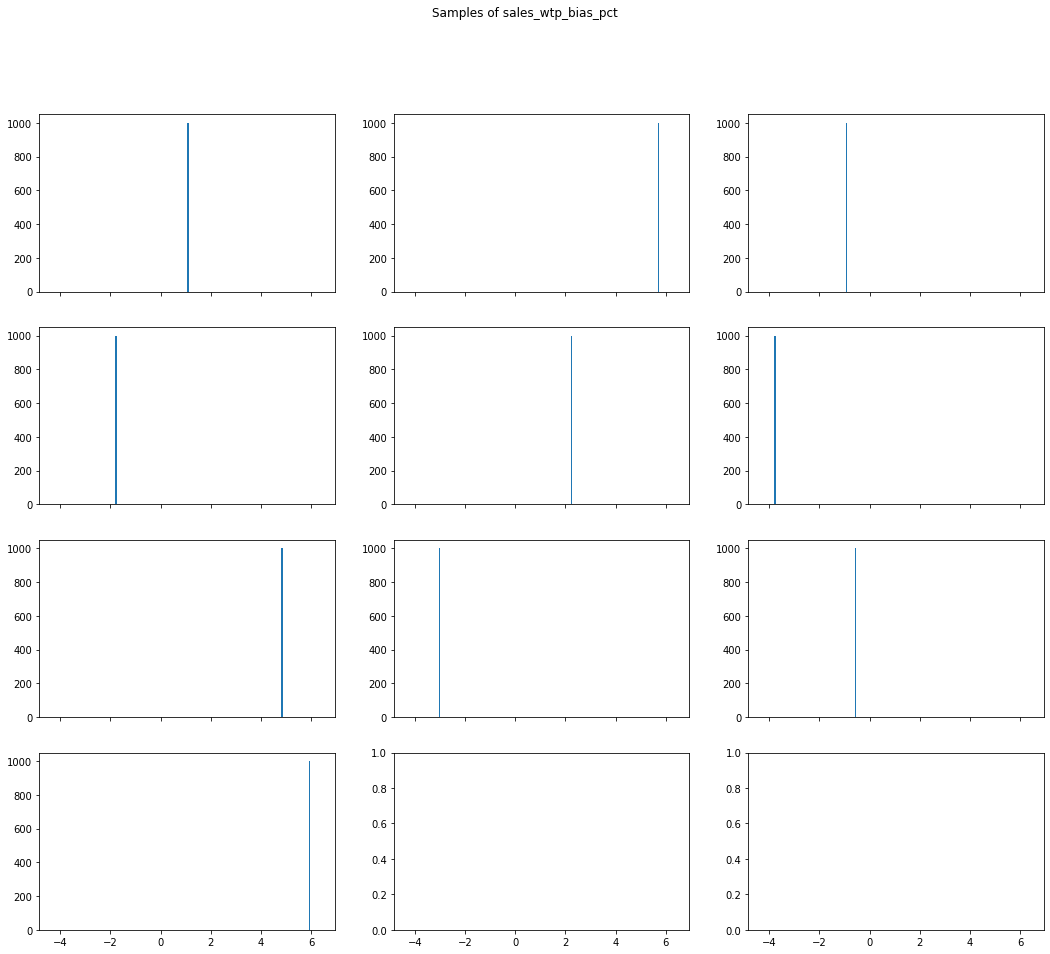

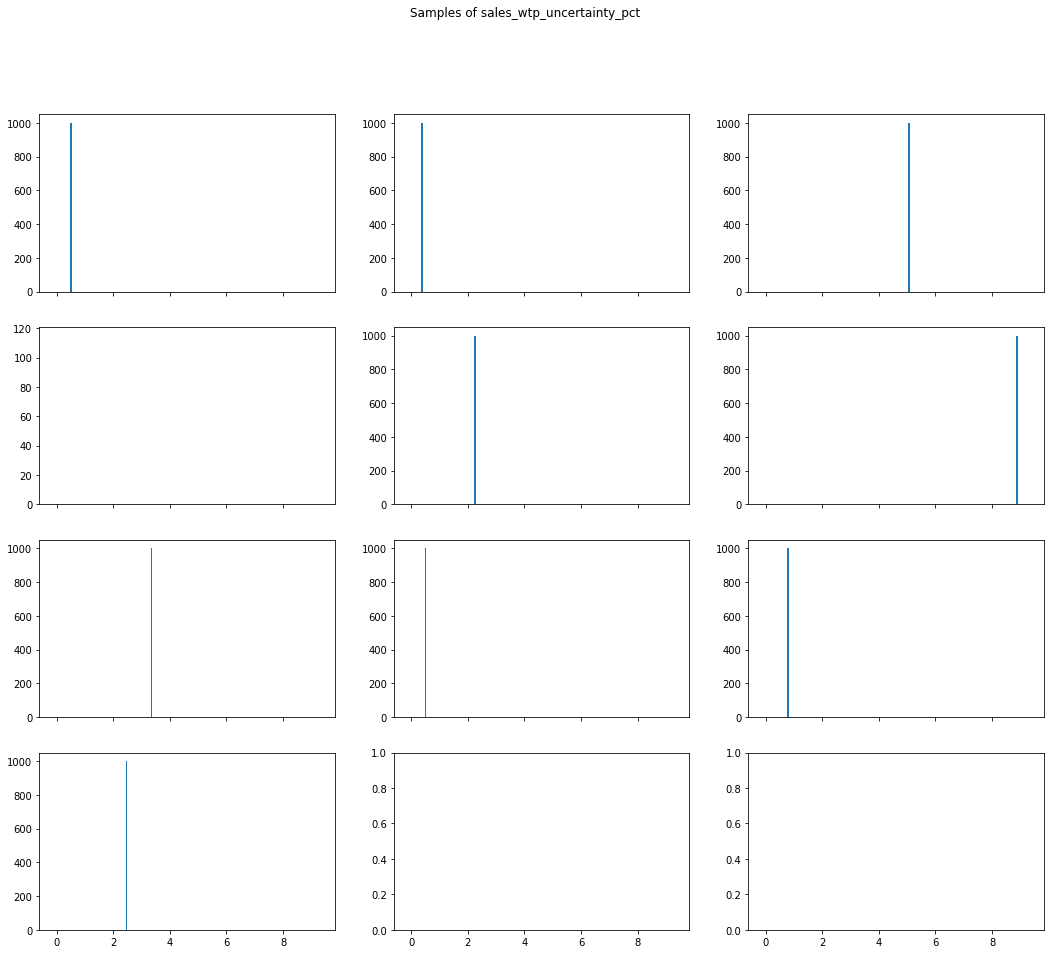

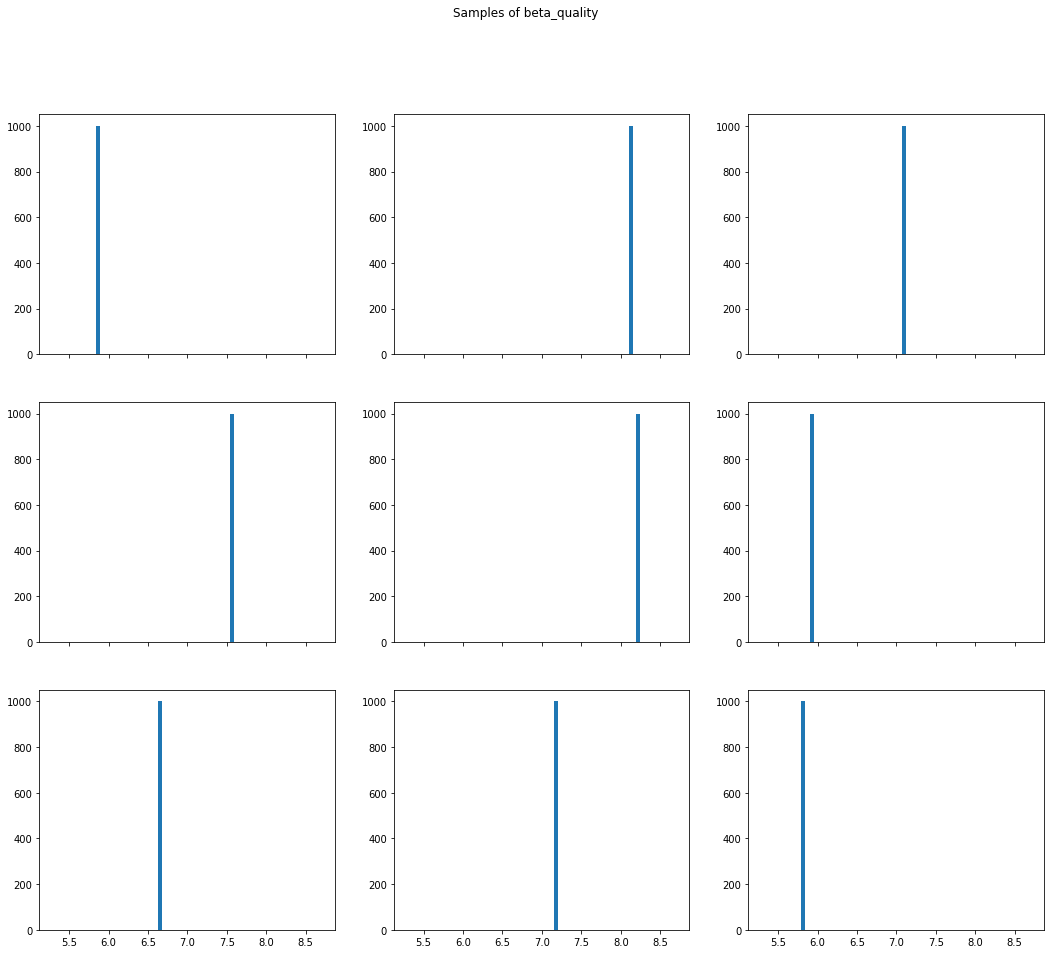

In [31]:
def plot_subsites(site):
    numplots = samples[site].shape[-1]
    columns = 3
    whole_rows, part_rows = divmod(numplots, columns)
    rows = whole_rows + int(part_rows>0)
    fig,axs = plt.subplots(rows,columns, figsize=(18,15), sharex=True)
    for i, ax in enumerate(axs.ravel()):
        if i < numplots:
            ax.hist(samples[site][:,i], bins = 20)
    plt.suptitle('Samples of ' + site)

plot_subsites('sales_wtp_bias_pct')
plot_subsites('sales_wtp_uncertainty_pct')
plot_subsites('beta_quality')
